In [1]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# https://fred.stlouisfed.org/categories/94
# DEXJPUS = USDJPY
# DEXUSEU = EURUSD
# DEXUSUK = GBPUSD
# DEXSZUS = USDCHF

#start = datetime.datetime(2005, 12, 1)
#end = datetime.datetime(2016, 1, 1)

#ccy = web.DataReader('DEXUSUK', 'fred', start, end)
#ccy.rename(columns={'DEXUSUK': 'price'}, inplace=True)
#ccy = ccy.fillna(method='pad')
#ccy.head()

In [3]:
start = datetime.datetime(2005, 12, 1)
end = datetime.datetime(2016, 1, 1)

ccy = web.DataReader('F', 'google', start, end)
ccy.rename(columns={'Close': 'price'}, inplace=True)
ccy = ccy.fillna(method='pad')
ccy.head()

,Open,High,Low,price,Volume
Date,,,,,
2005-12-01,8.24,8.30,7.96,8.10,30001500
2005-12-02,8.09,8.20,8.01,8.15,13325400
2005-12-05,8.10,8.11,7.99,8.06,17230300
2005-12-06,8.09,8.16,8.06,8.11,11626300
2005-12-07,8.20,8.29,8.11,8.20,19676600


In [4]:
ccy = ccy.assign(daily_ret = ccy.price.pct_change(1))
ccy = ccy.assign(yest_ret = ccy.daily_ret.shift(1))
ccy = ccy.assign(tmrw_price = ccy.price.shift(-1))
ccy = ccy.assign(tmrw_ret = ccy.daily_ret.shift(-1))
ccy = ccy.loc['20060101':]

In [5]:
def signal_oneday(row):
    if row.daily_ret > 0:
        return 1
    if row.daily_ret < 0:
        return -1
    return 0

ccy = ccy.assign(signal_oneday = ccy.apply(signal_oneday, axis=1))

def signal_twoinarow(row):
    if row.daily_ret > 0 and row.yest_ret > 0:
        return 1
    if row.daily_ret < 0 and row.yest_ret < 0:
        return -1
    return 0

ccy = ccy.assign(signal_twoinarow = ccy.apply(signal_twoinarow, axis=1))

def signal_incrmomentum(row):
    if row.daily_ret > 0 and row.yest_ret > 0 and row.daily_ret > row.yest_ret:
        return 1
    if row.daily_ret < 0 and row.yest_ret < 0 and row.daily_ret < row.yest_ret:
        return -1
    return 0

ccy = ccy.assign(signal_incrmomentum = ccy.apply(signal_incrmomentum, axis=1))


ccy.head()

,Open,High,Low,price,Volume,daily_ret,yest_ret,tmrw_price,tmrw_ret,signal_oneday,signal_twoinarow,signal_incrmomentum
Date,,,,,,,,,,,,
2006-01-03,7.72,7.83,7.66,7.83,16903600,0.014249,-0.011524,8.01,0.022989,1,0,0
2006-01-04,7.83,8.08,7.82,8.01,35626000,0.022989,0.014249,8.35,0.042447,1,1,1
2006-01-05,8.05,8.40,8.03,8.35,31987700,0.042447,0.022989,8.52,0.020359,1,1,1
2006-01-06,8.30,8.66,8.27,8.52,40423300,0.020359,0.042447,8.62,0.011737,1,1,0
2006-01-09,8.65,8.86,8.60,8.62,28958400,0.011737,0.020359,8.77,0.017401,1,1,0


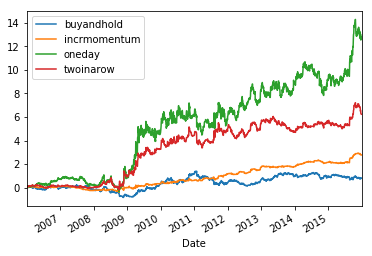

In [6]:
buyandhold = ((ccy.tmrw_ret)+1).cumprod()-1
oneday = ((ccy.signal_oneday * ccy.tmrw_ret)+1).cumprod()-1
twoinarow = ((ccy.signal_twoinarow * ccy.tmrw_ret)+1).cumprod()-1
incrmomentum = ((ccy.signal_incrmomentum * ccy.tmrw_ret)+1).cumprod()-1

ret = pd.DataFrame({
    'buyandhold': buyandhold,
    'oneday': oneday,
    'twoinarow': twoinarow, 
    'incrmomentum': incrmomentum
})
ret.plot()

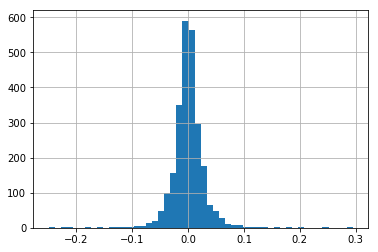

In [7]:
ccy.daily_ret.hist(bins=50)